<a href="https://colab.research.google.com/github/haosulab/ManiSkill2/blob/colab_updates/examples/tutorials/1_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Code

To begin, prepare the colab environment by clicking the play button below and make sure you are using a GPU runtime. This will install all dependencies for the future code. ManiSkill2 is as simple as `pip install mani_skill2` and is lightweight and fast to get started with.

In [ ]:
# below fixes some bugs introduced by some recent Colab changes
!mkdir -p /usr/share/vulkan/icd.d
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill2/main/docker/nvidia_icd.json
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill2/main/docker/10_nvidia.json
!mv nvidia_icd.json /usr/share/vulkan/icd.d
!mv 10_nvidia.json /usr/share/glvnd/egl_vendor.d/10_nvidia.json
# dependencies
#!pip install setuptools==65.5.0
!apt-get install -y --no-install-recommends libvulkan-dev
!pip install mani_skill2
!pip install --upgrade --no-cache-dir gdown

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    site.main() # run this so local pip installs are recognized

# Tutorial on Maniskill2 Environments and Working with Demonstrations


[ManiSkill2](https://github.com/haosulab/ManiSkill2) is an open-source, large-scale robotics benchmark that seeks to benchmark generalizable manipulation skills and robot learning.

The key features of ManiSkill2 are:
- Fast visual rendering (10x FPS compared to existing benchmarks, 1000FPS on a single GPU) with photorealistic capabilities
- 2000+ Objects and Expert Demonstrations Solving Every Environment
- 20+ Rigid and Soft-Body Tasks


This notebook goes over how to create and configure environments as well as work with our demonstration dataset. Our [ManiSkill2](https://github.com/haosulab/ManiSkill2) environments follow the new `gym` api with various robotics related customizations and demonstration dataset that enable research into different areas such as robotics, computer vision, and reinforcement learning. The environments are built on top of the [Sapien](sapien.ucsd.edu/) simulation environment.

For those interested in visual Reinforcement Learning and Imitation Learning workflows that leverage the fast visual simulation, we have provided a tutorial for each of those [here](https://github.com/haosulab/ManiSkill2/tree/main/examples/tutorials)

This tutorial will work with the PickCube environment, a simple but also commonplace robotics task.

In [3]:
# Import required packages
import gymnasium as gym
from tqdm.notebook import tqdm
import numpy as np
import mani_skill2.envs
import matplotlib.pyplot as plt

## 1 Create and configure environments

We can create ManiSkill environments by specifying a environment id. Further, observations, actions, and rewards are configurable with just a few lines of code

Action Space: Box(-1.0, 1.0, (8,), float32)


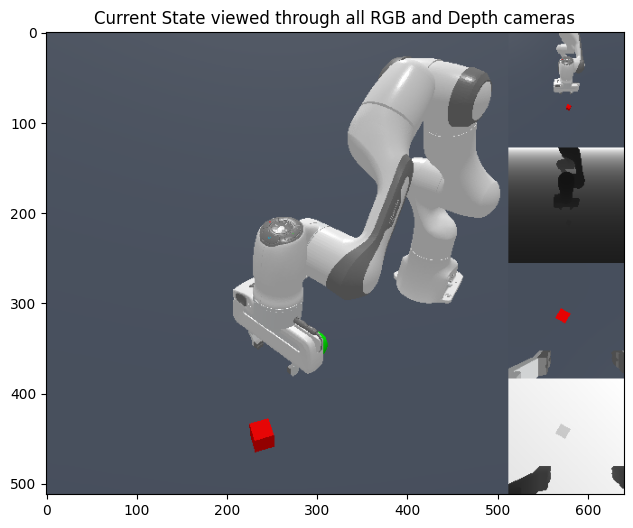

In [32]:
#@title 1.1 Choose an environment, observation mode, control mode, and reward
#@markdown Run this cell to display the action space of the chosen controller as well as the current view of the environment.
#@markdown The main part of the view is our view of the environment. The two views on the right are the RGB and Depth images from a third-person camera
#@markdown and a hand-mounted camera. The two views on the right are also the exact perspectives and orientations the robot gets in the rgbd and point cloud observation modes

# Can be any env_id from the list of Rigid-Body envs: https://haosulab.github.io/ManiSkill2/concepts/environments.html#rigid-body
# and Soft-Body envs: https://haosulab.github.io/ManiSkill2/concepts/environments.html#soft-body

# This tutorial allows you to play with 4 environments out of a total of 20 environments that ManiSkill provides
env_id = "PickCube-v0" #@param ['PickCube-v0', 'PegInsertionSide-v0', 'StackCube-v0', 'PlugCharger-v0']

# choose an observation type and space, see https://haosulab.github.io/ManiSkill2/concepts/observation.html for details
obs_mode = "rgbd" #@param can be one of ['pointcloud', 'rgbd', 'state_dict', 'state']

# choose a controller type / action space, see https://haosulab.github.io/ManiSkill2/concepts/controllers.html for a full list
control_mode = "pd_joint_delta_pos" #@param can be one of ['pd_ee_delta_pose', 'pd_ee_delta_pos', 'pd_joint_delta_pos', 'arm_pd_joint_pos_vel']

reward_mode = "dense" #@param can be one of ['sparse', 'dense']

# create an environment with our configs and then reset to a clean state
env = gym.make(env_id,
               obs_mode=obs_mode,
               reward_mode=reward_mode,
               control_mode=control_mode,
               enable_shadow=False)
obs, _ = env.reset()
print("Action Space:", env.action_space)

# take a look at the current state
img = env.unwrapped.render_cameras()
plt.figure(figsize=(10,6))
plt.title("Current State viewed through all RGB and Depth cameras")
plt.imshow(img)
env.close()

Run below to further visualize RGBD and Pointcloud observations

In [33]:
# some visualization functions for different observation modes
def show_camera_view(obs_camera, title):
    plt.figure()
    rgb, depth = obs_camera['rgb'], obs_camera['depth']
    plt.subplot(1,2,1)
    plt.title(f"{title} - RGB")
    plt.imshow(rgb)
    plt.subplot(1,2,2)
    plt.title(f"{title} - Depth")
    plt.imshow(depth[:,:, 0], cmap="gray")

def show_pointcloud(obs):
    import trimesh
    v = obs['pointcloud']['xyzw'][::,:3]
    s= trimesh.Scene([trimesh.points.PointCloud(v, obs['pointcloud']['rgb'])])
    return s.show()

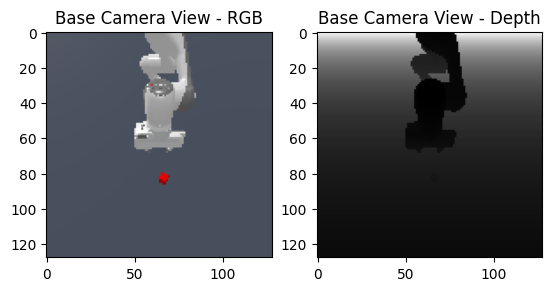

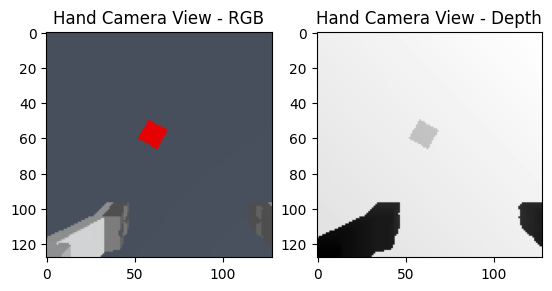

In [34]:
#@markdown Display the RGBD observation. Make sure you are using `obs_mode="rgbd"`
show_camera_view(obs['image']['base_camera'], "Base Camera View")
show_camera_view(obs['image']['hand_camera'], "Hand Camera View")

In [31]:
#@markdown Display the Pointcloud observation. Make sure you are using `obs_mode="pointcloud"`
show_pointcloud(obs)

### 1.2 Interactive Viewer and Recording videos

To create a replay video of what happened in an episode, we can use the `RecordEpisode` environment wrapper as so, and specify what we want to record.Note that recording replay videos adds some overhead so ensure you don't use this while training. You can also directly save rendered frames which is shown in Section 2.2.

`RecordEpisode` will always use what the `render_mode` specified at environment creation is, and in the code below we use "cameras" as shown earlier.

ManiSkill has an interactive viewer, available if you run locally on a machine with a GUI. You can render the current state with `env.human_render()` which will bring up a viewer. The script below will show the interactive viewer if it detects that it is not running in Colab.

To try and manually control a robot agent with your keyboard, you can run
```
python -m mani_skill2.examples.demo_manual_control -e PickCube-v0
```

In [35]:
from mani_skill2.utils.wrappers import RecordEpisode
# to make it look a little more realistic, we will enable shadows, and record the "cameras" render mode
env = gym.make(env_id, render_mode="cameras", enable_shadow=True)
env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    info_on_video=True # when True, will add informative text onto the replay video such as step counter, reward, and other metrics
)

# step through the environment with random actions
obs, _ = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if not IN_COLAB: env.human_render() # will render with a window if possible
env.flush_video() # Save the video
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True) # Watch our replay

2023-08-17 21:11:06,969 - mani_skill2 - WARNING - mani_skill2 is not installed with git.
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.get_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_state` for environment variables or `env.get_attr('get_state')` that will search the reminding wrappers.
  logger.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

## 2 Using demonstration data

A key feature of ManiSkill environments is that we provide a lot of demonstrations, so that users can start their *learning from demonstrations* research easily.

The following code will go through the basic usage of our large-scale robotics demonstration dataset.

Each environment comes with a `.h5` file composed of all the demonstrations. Moreover, each `.h5` file has an associated `.json` file defining the environment configuration used in those demonstrations. Here is how to download and load the demonstrations.

### 2.1 Download and load

We provide a simple command line tool to download demos. Specify an output folder and environment ID and it will download the appropriate demonstrations from our open sourced [Hugging Face Dataset](https://huggingface.co/datasets/haosulab/ManiSkill2)

In [15]:
# We provide a command line tool to download demonstrations.
!python -m mani_skill2.utils.download_demo {env_id} -o "demos"

34.2Mit [00:04, 7.45Mit/s]               
328kit [00:00, 813kit/s]       


To load the demonstration dataset, we use h5py and a load_json utility

In [19]:
import h5py
from mani_skill2.utils.io_utils import load_json

# Load the trajectory data from the .h5 file. Demonstrations are versioned and thus saved to "demos/<version>/..."
traj_path = f"demos/v0/rigid_body/{env_id}/trajectory.h5"
# You can also replace the above path with the trajectory you just recorded (./tmp/trajectory.h5)
h5_file = h5py.File(traj_path, "r")

# Load associated json
json_path = traj_path.replace(".h5", ".json")
json_data = load_json(json_path)

episodes = json_data["episodes"] # meta data of each episode
env_info = json_data["env_info"]
env_id = env_info["env_id"]
env_kwargs = env_info["env_kwargs"]

print("env_id:", env_id)
print("env_kwargs:", env_kwargs)
print("#episodes:", len(episodes))

env_id: PickCube-v0
env_kwargs: {'obs_mode': 'none', 'control_mode': 'pd_joint_pos'}
#episodes: 1000


The trajectory of each episode is stored under the `traj_{episode_id}` key in the HDF5 file. `episode_id` usually ranges from 0 to `len(episodes) - 1`.
`episode_id` and other meta information of episdoes are stored under the `episodes` key in the JSON file.
The raw trajectory contains 3 keys: `actions`, `env_states` and `success`. For soft-body environments, `env_states` is replaced by `env_init_state` (initial state) to reduce data storage.

In [20]:
traj_id = "traj_0"
traj_h5 = h5_file[traj_id]
for key in traj_h5:
    print(key, traj_h5[key].shape, traj_h5[key].dtype)

actions (88, 8) float32
env_states (89, 73) float32
success (88,) bool


**Note that the raw trajectories do not include actual observations.** We store both actions and environment states, which can be used to replay trajectories and generate desired observations (states, RGBD images, point cloud). Please see the following sections for how to replay and convert demonstrations to your desired observation and action spaces.

### 2.2 Replay demonstrations

To replay the trajectory of an episode, you need to first create an environment given the environment initialization keyword arguments stored in the JSON file. Additionally, you need to reset the environment with the same seed and other keyword arguments of the episode recorded in the JSON file. Then, the trajectory can be replayed by actions or environment states stored in the HDF5 file.

In [27]:
def replay(episode_idx, h5_file, json_data, render_mode="cameras", fps=20):
    episodes = json_data["episodes"]
    ep = episodes[episode_idx]
    # episode_id should be the same as episode_idx, unless specified otherwise
    episode_id = ep["episode_id"]
    traj = h5_file[f"traj_{episode_id}"]

    # Create the environment
    env_kwargs = json_data["env_info"]["env_kwargs"]
    env = gym.make(env_id, render_mode="rgb_array", **env_kwargs)
    # Reset the environment
    reset_kwargs = ep["reset_kwargs"].copy()
    reset_kwargs["seed"] = ep["episode_seed"]
    env.reset(**reset_kwargs)

    frames = [env.render()]

    for i in tqdm(range(len(traj["actions"]))):
        action = traj["actions"][i]
        obs, reward, terminated, truncated, info = env.step(action)
        if not IN_COLAB: env.human_render()
        frames.append(env.render())

    env.close()
    del env
    return frames

In [28]:
#@markdown Choose an episode ID here and run this cell to watch a replay of a expert demo. Note that this can be a little slow as this code generates a video. To run faster we recommend watching on a machine with a GUI and running only the replay function.
from mani_skill2.utils.visualization.jupyter_utils import display_images

episode_idx = 3 #@param {type:"integer"}
frames = replay(episode_idx, h5_file, json_data)
display_images(frames, format="jshtml",  repeat=True, cache_frame_data=False, interval=50)

  0%|          | 0/90 [00:00<?, ?it/s]

### 2.3 Convert demonstrations across observation/action spaces

The demonstration dataset does not include actual observations. You can convert trajectories to the desired observation space and action space. We provide a tool to help replay and convert trajectories.

```python
# Replay the trajectory to `rgbd` observations and the `pd_ee_delta_pose` controller with 10 processes in parallel
python -m mani_skill2.trajectory.replay_trajectory --traj-path \
 demos/v0/rigid_body/PickCube-v0/trajectory.h5 --save-traj --obs-mode rgbd --target-control-mode pd_ee_delta_pose --num-procs 10
```

The above command will generate the file `demos/v0/rigid_body/PickCube-v0/trajectory.rgbd.pd_ee_delta_pose.h5` and its associated json metadata file. In general, generating trajectories like this will separate them based on the file name, which specifies the observation mode and control mode.